<a href="https://colab.research.google.com/github/2xazo/SDAIA-Weak5-NLP/blob/main/07_information_retrieval_ex_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval

## Overview

This lab provides hands-on practice building a complete **Search Engine** from scratch using **TF-IDF (Term Frequency-Inverse Document Frequency)**, one of the most common techniques in Information Retrieval. You'll work with real datasets, implement TF-IDF vectorization, measure document similarity using cosine similarity, and build a functional search engine that can retrieve and rank documents based on user queries. This lab demonstrates the practical application of IR concepts in building production-ready search systems.

> A 2015 survey showed that 83% of text-based recommender systems in digital libraries used TF-IDF.

## Outline

1. **Setup and Imports** - Installing dependencies and importing libraries
2. **Dataset Loading** - Loading the 20 Newsgroups dataset from scikit-learn
3. **Text Preprocessing** - Preparing documents for vectorization
4. **TF-IDF Vectorization** - Converting documents and queries into numerical vectors
5. **Building the Search Engine**:
   - **Retrieval**: Finding the most similar documents to a query using cosine similarity
   - **Ranking**: Ordering documents by relevance score
   - **Classification**: Classifying queries into one of the 20 categories
6. **Testing the Search Engine** - Querying and evaluating results
7. **Understanding Results** - Interpreting search results and similarity scores

## Learning Objectives

By the end of this lab, you will be able to:

- Recognize the term-document matrix produced by the TF-IDF algorithm
- Understand how similarity is measured between text vectors (cosine similarity)
- **Work with real datasets**.
- **Implement a TF-IDF-based search engine** using:
  - Scikit-learn's `TfidfVectorizer`
  - Cosine similarity for document ranking
  - Sparse matrices for efficient storage

## Glossary of Terms

**Information Retrieval (IR)**: The task of finding information (usually documents) that satisfies an information need from within large collections.

**Corpus**: A collection of documents. In IR, this is the entire set of documents we search through.

**Query**: A user's information need expressed in natural language (e.g., "What is machine learning?").

**Document**: A unit of information in the corpus (e.g., a web page, article, or text passage).

**TF-IDF (Term Frequency-Inverse Document Frequency)**: A numerical statistic that reflects how important a word is to a document in a collection. As you learned in the vectorization lesson:
- **TF (Term Frequency)**: How often a term appears in a document
- **IDF (Inverse Document Frequency)**: How rare or common a term is across the entire corpus
- **TF-IDF**: TF × IDF, giving higher weight to terms that are frequent in a document but rare in the corpus

**Vector Space Model**: A model where documents and queries are represented as vectors in a high-dimensional space. Similarity is measured using the angle between vectors (cosine similarity).

**Cosine Similarity**: A measure of similarity between two vectors. It measures the cosine of the angle between them, ranging from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF).

**Sparse Matrix**: A matrix where most elements are zero. TF-IDF vectors are typically sparse because most words don't appear in most documents.

**Retrieval**: The process of finding and ranking documents in response to a query.

**Ranking**: Ordering retrieved documents by their relevance score (highest to lowest).

## References

- [20 Newsgroups Dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)
- [Scikit-learn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Scikit-learn cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

## The Complete Pipeline

1. **Dataset Loading**: Load the 20 Newsgroups dataset from scikit-learn
2. **Text Preprocessing**: Prepare documents for vectorization (as learned in previous lessons)
3. **TF-IDF Vectorization**: Convert documents and queries into numerical vectors
4. Model:
   1. **Retrieval**: Find the most similar documents to a query using **cosine similarity**
   2. **Classification**: Classify a query into one of the 20 categories

### Import Libraries

We group imports by category following Python best practices. All libraries used here are part of the standard scikit-learn ecosystem:


In [1]:
# %pip install joblib==1.5.3 numpy==1.26.4 pandas==2.3.3 scikit-learn==1.8.0 --quiet

In [2]:
# Standard library imports
import json
from collections import defaultdict

# Third-party imports
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading the 20 Newsgroups Dataset

We'll use scikit-learn's **20 Newsgroups dataset**, a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. This is a classic dataset for text classification and information retrieval experiments.

**About the Dataset:**
- **20 categories** of newsgroups (e.g., comp.graphics, rec.sport.baseball, sci.med)
- Each document is a newsgroup post with subject and body text
- Documents are organized by topic, which we'll use to create relevance judgments

We'll load the 20 Newsgroups dataset using scikit-learn's `fetch_20newsgroups` function. This dataset contains newsgroup posts organized into 20 categories.


In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
fetch_20newsgroups?

In [5]:
# Load the 20 Newsgroups dataset
# We'll use the training set as our document collection
# remove=('headers', 'footers', 'quotes') removes metadata to focus on content
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42,
)

Loading 20 Newsgroups dataset...


### Exercise 1: Explore the Dataset

**Task:**

- The distribution of documents across categories
- The content of sample documents
- Notice that documents are organized by topic (category)

In [6]:
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': newsgroups.target,
    'category_name': [newsgroups.target_names[newsgroups.target[i]] for i in range(len(newsgroups.target))]
})
df.head()

,text,category,category_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


<Axes: xlabel='category'>

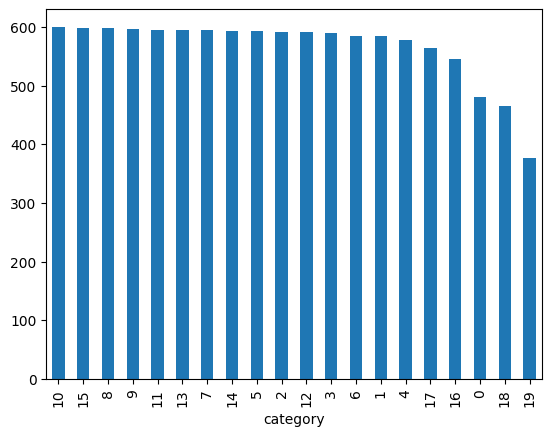

In [7]:
df['category'].value_counts().plot.bar()

### Drop columns and keep `text` only

In [8]:
df = df[['text']]
df

,text
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,I just installed a DX2-66 CPU in a clone mothe...
11312,\nWouldn't this require a hyper-sphere. In 3-...


## Building the Search Engine

Now we'll build a TF-IDF-based search engine. The process involves:

1. **Creating TF-IDF vectors** for all documents
2. **Implementing a retrieval function**

### How TF-IDF enables retrieval

- TF-IDF weights words by their importance: rare words that appear frequently in a document get high scores
- When a user searches for "machine learning", documents with high TF-IDF scores for those terms are likely relevant
- The query is also converted to a TF-IDF vector, then compared to all document vectors

**Cosine Similarity for Document Matching**

To find relevant documents, we need to measure **similarity** between the query vector and document vectors.

**Cosine Similarity** measures the angle between two vectors:
- It ranges from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF)
- **1.0** = vectors point in the same direction (very similar)
- **0.0** = vectors are perpendicular (no similarity)
- **-1.0** = vectors point in opposite directions (very dissimilar)

**Why cosine similarity?**
- It measures similarity in **direction**, not magnitude
- A long document and a short document about the same topic will have similar directions (high cosine similarity)
- It's robust to document length differences
- Works well with sparse TF-IDF vectors

**The retrieval process:**
1. Convert query to TF-IDF vector (using the same vocabulary as documents)
2. Compute cosine similarity between query vector and all document vectors
3. Rank documents by similarity score (highest first)
4. Return top-k most similar documents

### Task 1: Creating TF-IDF vectors for all documents

In [9]:
# Step 2: Create TF-IDF vectors for all documents
# Initialize the vectorizer
# We use default settings, but you can customize:
# - max_features: limit vocabulary size
# - stop_words: remove common words ('english')
# - ngram_range: use unigrams and bigrams
vectorizer = TfidfVectorizer(
    lowercase=True,      # Convert to lowercase
    stop_words='english', # Remove English stop words
    max_features=5000,   # Limit vocabulary to top 5000 terms
    ngram_range=(1, 2)   # Use both unigrams and bigrams
)

In [10]:
# Fit on all documents and transform them
# This learns the vocabulary and IDF from the corpus
document_vectors = vectorizer.fit_transform(df['text'])
document_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 504063 stored elements and shape (11314, 5000)>

In [11]:
print(f"Document vectors shape: {document_vectors.shape}")
print(f"  - {document_vectors.shape[0]} documents")
print(f"  - {document_vectors.shape[1]} features (terms in vocabulary)")
print("\nThis is a sparse matrix. Let's check sparsity:")
print(f"  - Non-zero elements: {document_vectors.nnz:,}")
print(f"  - Total elements: {document_vectors.shape[0] * document_vectors.shape[1]:,}")
print(f"  - Sparsity: {(1 - document_vectors.nnz / (document_vectors.shape[0] * document_vectors.shape[1])) * 100:.2f}%")

Document vectors shape: (11314, 5000)
  - 11314 documents
  - 5000 features (terms in vocabulary)

This is a sparse matrix. Let's check sparsity:
  - Non-zero elements: 504,063
  - Total elements: 56,570,000
  - Sparsity: 99.11%


> Notice how the sparse matrix efficiently stores only non-zero values. This is why TF-IDF scales well to large document collections.

- Document vectors shape: (~11,000, 5000) - thousands of documents, 5000 features
- High sparsity (typically 95-99%) - most values are zero

Notice how there is a lot of junk in the text, when we print the vocabulary from `200:400`, this may or may not be useful, depending on your use case.

In [12]:
# Show some vocabulary terms
vocab = vectorizer.get_feature_names_out()
print(vocab[200:400])

['42' '43' '44' '45' '46' '47' '48' '486' '49' '4e' '4k' '4l' '4t' '4th'
 '4u' '50' '500' '5000' '51' '52' '53' '54' '55' '56' '57' '58' '59' '5g'
 '5g9p' '5g9v' '5k' '5s' '5u' '60' '600' '6000' '61' '617' '62' '63' '64'
 '64 bit' '65' '650' '66' '67' '68' '69' '6e' '6ei' '6ei 6ei' '6g' '6um'
 '6um 6um' '70' '700' '703' '71' '72' '73' '74' '75' '750' '75u' '75u 75u'
 '76' '77' '78' '79' '7ex' '7ey' '7ey 7ey' '7ez' '7klj' '7kn' '7th' '7u'
 '80' '80 bit' '800' '81' '82' '83' '84' '85' '86' '87' '88' '89' '8n'
 '8v' '90' '900' '91' '91 92' '92' '93' '94' '95' '96' '97' '98' '99' '9d'
 '9f' '9f8' '9f9' '9l' '9l3' '9p' '9s' '9v' '9v g9v' '__' '___' '____'
 '_____' '_q' '_the' 'a4' 'a7' 'a86' 'a86 a86' 'a86 lg' 'a86r' 'ab' 'abc'
 'abiding' 'ability' 'able' 'abortion' 'abs' 'absolute' 'absolutely'
 'abuse' 'ac' 'ac uk' 'academic' 'accelerator' 'accept' 'acceptable'
 'accepted' 'access' 'accident' 'accidents' 'accomplished' 'according'
 'account' 'accounts' 'accurate' 'achieve' 'acid' 'acquire

### Task 2: Implementing a retrieval function

- Converts a query to a TF-IDF vector
- Computes cosine similarity with all document vectors
- Returns the top-k most similar documents

In [13]:
# Step 3: Implement the retrieval function
def retrieve_documents(query_text, top_k=10):
    # Transform query to TF-IDF vector using the same vectorizer
    query_vector = vectorizer.transform([query_text])

    # Compute cosine similarity between query and all documents
    # cosine_similarity returns a matrix of shape (1, num_documents)
    similarities = cosine_similarity(query_vector, document_vectors).flatten()

    # Get indices of top-k documents (sorted by similarity, descending)
    top_indices = np.argsort(similarities)[::-1][:top_k]

    # Return a dataframe with the top-k results
    df_results = df.iloc[top_indices].copy()
    df_results['similarity'] = similarities[top_indices]
    return df_results

In [14]:
search_results = retrieve_documents(query_text='computer', top_k=3)
search_results

,text,similarity
9137,\nWhat about the common joystick found in all ...,0.675917
8258,\n\nRumor has it that a guy at Dell Computer h...,0.650509
8464,\n Computers are a special case.. and it's a p...,0.517928


> **Note:** how the top three results are all related to the query.

## **Student Exercise**: build a search engine on the `CVs` dataset

In [15]:
# STUDENT EXERCISE
import os
if not os.path.exists('B5'):
    !git clone https://github.com/HassanAlgoz/B5.git

Cloning into 'B5'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 741 (delta 42), reused 28 (delta 28), pack-reused 675 (from 2)
Receiving objects: 100% (741/741), 35.22 MiB | 36.03 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [16]:
import glob
import json

cv_files = glob.glob('B5/W5_NLP/M1/datasets/CVs/**/*.json', recursive=True)

print(f"Number of CVs found: {len(cv_files)}")
print(f"\nFirst 10 files:")
for i, file in enumerate(cv_files[:10], 1):
    print(f"  {i}. {file}")

if len(cv_files) > 10:
    print(f"  ... and {len(cv_files) - 10} more files")

Number of CVs found: 40

First 10 files:
  1. B5/W5_NLP/M1/datasets/CVs/Topic_1/22.json
  2. B5/W5_NLP/M1/datasets/CVs/Topic_1/15.json
  3. B5/W5_NLP/M1/datasets/CVs/Topic_1/26.json
  4. B5/W5_NLP/M1/datasets/CVs/Topic_1/10.json
  5. B5/W5_NLP/M1/datasets/CVs/Topic_1/20.json
  6. B5/W5_NLP/M1/datasets/CVs/Topic_1/05_en.json
  7. B5/W5_NLP/M1/datasets/CVs/Topic_1/30.json
  8. B5/W5_NLP/M1/datasets/CVs/Topic_1/40.json
  9. B5/W5_NLP/M1/datasets/CVs/Topic_1/33.json
  10. B5/W5_NLP/M1/datasets/CVs/Topic_1/17.json
  ... and 30 more files


In [17]:
if cv_files:
    print("Inspecting first CV file...")
    print("=" * 70)

    sample_cv = cv_files[0]
    print(f"File: {sample_cv}\n")

    with open(sample_cv, 'r', encoding='utf-8') as f:
        cv_data = json.load(f)

    if isinstance(cv_data, dict):
        print(f"Type: Dictionary with {len(cv_data)} keys")
        print(f"\nKeys found: {list(cv_data.keys())}\n")

        for key, value in cv_data.items():
            if isinstance(value, str):
                preview = value[:80] + "..." if len(value) > 80 else value
                print(f"  - {key}: {preview}")
            else:
                print(f"  - {key}: {value}")

    print("\n" + "=" * 70)
    print("Full content of first CV:")
    print("=" * 70)
    print(json.dumps(cv_data, indent=2, ensure_ascii=False))

Inspecting first CV file...
File: B5/W5_NLP/M1/datasets/CVs/Topic_1/22.json

Type: Dictionary with 5 keys

Keys found: ['Heading', 'Skills', 'Projects', 'Experience', 'Education']

  - Heading: Ibrahim Al-Saeed, AI Engineer
  - Skills: ['*', '**Programming:**', 'Python,', 'SQL. *', '**Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Keras. *', '**Computer', 'Vision:**', 'OpenCV,', 'YOLO,', 'Faster', 'R-CNN. *', '**Cloud:**', 'GCP', '(AI', 'Platform,', 'Cloud', 'Functions),', 'Docker.  ---']
  - Projects: ['Object Detection for Retail Analytics | Computer Vision Specialist [02/2023 - 06/2023]  Trained a YOLOv7 model to detect and count products on retail shelves.  The system provided real-time inventory data with 98% accuracy.', 'Image Captioning Model | Deep Learning Researcher [07/2022 - 11/2022]  Implemented an attention-based Encoder-Decoder model to generate captions for images.  Achieved a BLEU score of 0.35 on the COCO dataset.  ---']
  - Experience: ['AI Engineer', 'Zain | Kuwa

In [18]:
import pandas as pd
import os

cvs_data = []

for cv_file in cv_files:
    try:
        with open(cv_file, 'r', encoding='utf-8') as f:
            cv_json = json.load(f)

        if isinstance(cv_json, dict):
            text_parts = []
            for key, value in cv_json.items():
                if isinstance(value, str):
                    text_parts.append(f"{key}: {value}")
                elif isinstance(value, (list, dict)):
                    text_parts.append(f"{key}: {str(value)}")

            combined_text = "\n".join(text_parts)
        else:
            combined_text = str(cv_json)

        cvs_data.append({
            'filename': os.path.basename(cv_file),
            'filepath': cv_file,
            'text': combined_text
        })

    except Exception as e:
        print(f"Error reading {cv_file}: {e}")

df_cvs = pd.DataFrame(cvs_data)

print(f"Successfully loaded {len(df_cvs)} CVs!")
print(f"\nDataFrame shape: {df_cvs.shape}")
print(f"   - {df_cvs.shape[0]} CVs")
print(f"   - {df_cvs.shape[1]} columns")

print(f"\nData preview:")
df_cvs.head(3)

Successfully loaded 40 CVs!

DataFrame shape: (40, 3)
   - 40 CVs
   - 3 columns

Data preview:


,filename,filepath,text
0,22.json,B5/W5_NLP/M1/datasets/CVs/Topic_1/22.json,"Heading: Ibrahim Al-Saeed, AI Engineer\nSkills..."
1,15.json,B5/W5_NLP/M1/datasets/CVs/Topic_1/15.json,"Heading: Sultan Al-Fahim, AI Engineer\nSkills:..."
2,26.json,B5/W5_NLP/M1/datasets/CVs/Topic_1/26.json,"Heading: Hamad Al-Ghanim, Data Scientist\nSkil..."


In [19]:
print("=" * 70)
print("CV Statistics")
print("=" * 70)

df_cvs['text_length'] = df_cvs['text'].apply(len)

print(f"\nCV text length statistics (in characters):")
print(df_cvs['text_length'].describe())

print(f"\n" + "=" * 70)
print("Example: First CV Content")
print("=" * 70)
print(f"File: {df_cvs.iloc[0]['filename']}")
print("-" * 70)
print(df_cvs.iloc[0]['text'])
print("=" * 70)

CV Statistics

CV text length statistics (in characters):
count      40.000000
mean     1636.350000
std       195.162858
min      1365.000000
25%      1523.500000
50%      1572.000000
75%      1692.750000
max      2180.000000
Name: text_length, dtype: float64

Example: First CV Content
File: 22.json
----------------------------------------------------------------------
Heading: Ibrahim Al-Saeed, AI Engineer
Skills: ['*', '**Programming:**', 'Python,', 'SQL. *', '**Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Keras. *', '**Computer', 'Vision:**', 'OpenCV,', 'YOLO,', 'Faster', 'R-CNN. *', '**Cloud:**', 'GCP', '(AI', 'Platform,', 'Cloud', 'Functions),', 'Docker.  ---']
Projects: ['Object Detection for Retail Analytics | Computer Vision Specialist [02/2023 - 06/2023]  Trained a YOLOv7 model to detect and count products on retail shelves.  The system provided real-time inventory data with 98% accuracy.', 'Image Captioning Model | Deep Learning Researcher [07/2022 - 11/2022]  Implemente

In [20]:
import re
import string

def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\S+@\S+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    text = ' '.join(text.split())

    return text

print("Text preprocessing function created successfully!")

Text preprocessing function created successfully!


In [21]:
print("Applying preprocessing to all CVs...")
print("=" * 70)

print("BEFORE preprocessing:")
print("-" * 70)
print(df_cvs.iloc[0]['text'][:300])
print("\n")

df_cvs['text_cleaned'] = df_cvs['text'].apply(preprocess_text)

print("AFTER preprocessing:")
print("-" * 70)
print(df_cvs.iloc[0]['text_cleaned'][:300])
print("\n")

print("=" * 70)
print("Preprocessing Statistics:")
print(f"  - Original avg length: {df_cvs['text'].str.len().mean():.0f} chars")
print(f"  - Cleaned avg length: {df_cvs['text_cleaned'].str.len().mean():.0f} chars")
print(f"  - Reduction: {(1 - df_cvs['text_cleaned'].str.len().mean() / df_cvs['text'].str.len().mean()) * 100:.1f}%")
print("=" * 70)

Applying preprocessing to all CVs...
BEFORE preprocessing:
----------------------------------------------------------------------
Heading: Ibrahim Al-Saeed, AI Engineer
Skills: ['*', '**Programming:**', 'Python,', 'SQL. *', '**Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Keras. *', '**Computer', 'Vision:**', 'OpenCV,', 'YOLO,', 'Faster', 'R-CNN. *', '**Cloud:**', 'GCP', '(AI', 'Platform,', 'Cloud', 'Functions),', 'Docker.


AFTER preprocessing:
----------------------------------------------------------------------
heading ibrahim al saeed ai engineer skills programming python sql deep learning pytorch tensorflow keras computer vision opencv yolo faster r cnn cloud gcp ai platform cloud functions docker projects object detection for retail analytics computer vision specialist trained a yolov model to detect an


Preprocessing Statistics:
  - Original avg length: 1636 chars
  - Cleaned avg length: 1323 chars
  - Reduction: 19.1%


In [22]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


def advanced_preprocess(text):
    text = preprocess_text(text)

    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]

    return ' '.join(stemmed_words)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_cvs = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

print("Converting CVs to TF-IDF vectors...")
cv_vectors = vectorizer_cvs.fit_transform(df_cvs['text_cleaned'])
print("Conversion complete!\n")

print("=" * 70)
print("TF-IDF Matrix Information")
print("=" * 70)
print(f"Matrix shape: {cv_vectors.shape}")
print(f"   - {cv_vectors.shape[0]} CVs")
print(f"   - {cv_vectors.shape[1]} unique terms in vocabulary")
print(f"\nStorage information:")
print(f"   - Non-zero elements: {cv_vectors.nnz:,}")
print(f"   - Total possible elements: {cv_vectors.shape[0] * cv_vectors.shape[1]:,}")
print(f"   - Sparsity: {(1 - cv_vectors.nnz / (cv_vectors.shape[0] * cv_vectors.shape[1])) * 100:.2f}%")
print(f"\nNote: Sparse matrix (mostly zeros) saves memory!")

Converting CVs to TF-IDF vectors...
Conversion complete!

TF-IDF Matrix Information
Matrix shape: (40, 1331)
   - 40 CVs
   - 1331 unique terms in vocabulary

Storage information:
   - Non-zero elements: 5,166
   - Total possible elements: 53,240
   - Sparsity: 90.30%

Note: Sparse matrix (mostly zeros) saves memory!


In [24]:
vocabulary = vectorizer_cvs.get_feature_names_out()

print("=" * 70)
print("TF-IDF Vocabulary Sample")
print("=" * 70)
print(f"Total vocabulary size: {len(vocabulary)}\n")

print("First 50 words in vocabulary:")
for i in range(0, min(50, len(vocabulary)), 10):
    words = vocabulary[i:i+10]
    print(f"  {', '.join(words)}")

print("\nSearching for expected important keywords:")
important_keywords = ['python', 'java', 'machine learning', 'data', 'experience',
                      'education', 'skills', 'developer', 'engineer', 'data science']

found_keywords = [word for word in important_keywords if word in vocabulary]
print(f"  Found: {', '.join(found_keywords) if found_keywords else 'None'}")

TF-IDF Vocabulary Sample
Total vocabulary size: 1331

First 50 words in vocabulary:
  abdulaziz, abdulaziz university, abdullah, abdullah al, abdullah data, abdulrahman, abu, abu dhabi, accepted, access
  accuracy, achieved, achieving, acl, acl emnlp, actions, ad, ad hoc, adherence, administration
  administrator, advanced, advanced sql, agile, ahmed, ahsa, ai, ai engineer, ai machine, ai powered
  ai projects, ai solutions, ai specialist, ain, airflow, airflow languages, airflow projects, al abdullah, al ahsa, al ghamdi
  al qahtani, alation, algorithm, amazon, american, american university, analysis, analysis data, analyst, analyst associate

Searching for expected important keywords:
  Found: python, java, machine learning, developer, engineer, data science


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search_cvs(query, top_k=5, show_details=True):
    query_vector = vectorizer_cvs.transform([query])

    similarities = cosine_similarity(query_vector, cv_vectors).flatten()

    top_indices = np.argsort(similarities)[::-1][:top_k]

    results = df_cvs.iloc[top_indices].copy()
    results['similarity_score'] = similarities[top_indices]
    results['rank'] = range(1, len(top_indices) + 1)

    results = results[['rank', 'filename', 'similarity_score', 'text', 'filepath']]

    if show_details:
        print("=" * 70)
        print(f"Search results for: '{query}'")
        print("=" * 70)

        for idx, row in results.iterrows():
            print(f"\nRank #{row['rank']} - {row['filename']}")
            print(f"   Similarity score: {row['similarity_score']:.4f}")
            print(f"   Content preview:")
            preview = row['text'][:300].replace('\n', ' ')
            print(f"   {preview}...")
            print("-" * 70)

    return results

print("Search function ready to use!")
print("Example: search_cvs('Python Machine Learning', top_k=5)")

Search function ready to use!
Example: search_cvs('Python Machine Learning', top_k=5)


In [26]:
# Search for candidates with Python and Machine Learning
query1 = "Python Machine Learning Data Science"

results1 = search_cvs(query1, top_k=5)

Search results for: 'Python Machine Learning Data Science'

Rank #1 - 30.json
   Similarity score: 0.1783
   Content preview:
   Heading: Nouf Al-Hamad, AI Engineer Skills: ['*', '**Model', 'Deployment:**', 'BentoML,', 'TorchServe. *', '**Experiment', 'Tracking:**', 'MLflow,', 'Weights', '&', 'Biases. *', '**Cloud:**', 'Azure', 'ML,', 'GCP', 'Vertex', 'AI. *', '**Containerization:**', 'Docker,', 'Podman. *', '**Automation:**'...
----------------------------------------------------------------------

Rank #2 - 01_en.json
   Similarity score: 0.1757
   Content preview:
   Heading: Ahmed Al-Otaibi, AI Engineer Skills: ['*', '**Programming', 'Languages:**', 'Python,', 'C++,', 'SQL. *', '**Machine', '&', 'Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Scikit-learn,', 'Keras,', 'Hugging', 'Face', '(Transformers). *', '**Deployment', '&', 'Cloud', 'Computing:**', 'Dock...
----------------------------------------------------------------------

Rank #3 - 15.json
   Similarity score: 0.1695
 

In [27]:
# Search for candidates with Java and Backend Development
query2 = "Java Backend Developer Spring Boot"

results2 = search_cvs(query2, top_k=5)

Search results for: 'Java Backend Developer Spring Boot'

Rank #1 - 34.json
   Similarity score: 0.1412
   Content preview:
   Heading: Laila Al-Qahtani, AI Engineer Skills: ['*', '**LLMs:**', 'Fine-tuning,', 'Prompt', 'Engineering,', 'Retrieval-Augmented', 'Generation', '(RAG). *', '**Frameworks:**', 'LangChain,', 'LlamaIndex,', 'Hugging', 'Face. *', '**Backend:**', 'Python,', 'FastAPI,', 'Node.js. *', '**Vector', 'DBs:**'...
----------------------------------------------------------------------

Rank #2 - 30.json
   Similarity score: 0.0905
   Content preview:
   Heading: Nouf Al-Hamad, AI Engineer Skills: ['*', '**Model', 'Deployment:**', 'BentoML,', 'TorchServe. *', '**Experiment', 'Tracking:**', 'MLflow,', 'Weights', '&', 'Biases. *', '**Cloud:**', 'Azure', 'ML,', 'GCP', 'Vertex', 'AI. *', '**Containerization:**', 'Docker,', 'Podman. *', '**Automation:**'...
----------------------------------------------------------------------

Rank #3 - 02_en.json
   Similarity score: 0.0490
   

In [28]:
# Search for candidates with Web Development
query3 = "JavaScript React Frontend Web Development"

results3 = search_cvs(query3, top_k=5)

Search results for: 'JavaScript React Frontend Web Development'

Rank #1 - 14.json
   Similarity score: 0.0830
   Content preview:
   Heading: Noora Al-Thani, Data Analyst Skills: ['*', '**BI', 'Tools:**', 'Tableau,', 'Power', 'BI,', 'Qlik', 'Sense. *', '**Data', 'Tools:**', 'SQL,', 'Excel,', 'Google', 'Analytics. *', '**Data', 'Warehousing:**', 'Understanding', 'of', 'Star', 'Schema,', 'Snowflake. *', '**Business', 'Acumen:**', '...
----------------------------------------------------------------------

Rank #2 - 27.json
   Similarity score: 0.0639
   Content preview:
   Heading: Fatima bint Faisal, Data Analyst Skills: ['*', '**BI', 'Platforms:**', 'Power', 'BI,', 'Tableau. *', '**Data', 'Querying:**', 'Advanced', 'SQL,', 'DAX. *', '**Data', 'Preparation:**', 'Excel', 'Power', 'Query,', 'Alteryx. *', '**Storytelling:**', 'Strong', 'ability', 'to', 'communicate', 'i...
----------------------------------------------------------------------

Rank #3 - 13.json
   Similarity score: 0.0635

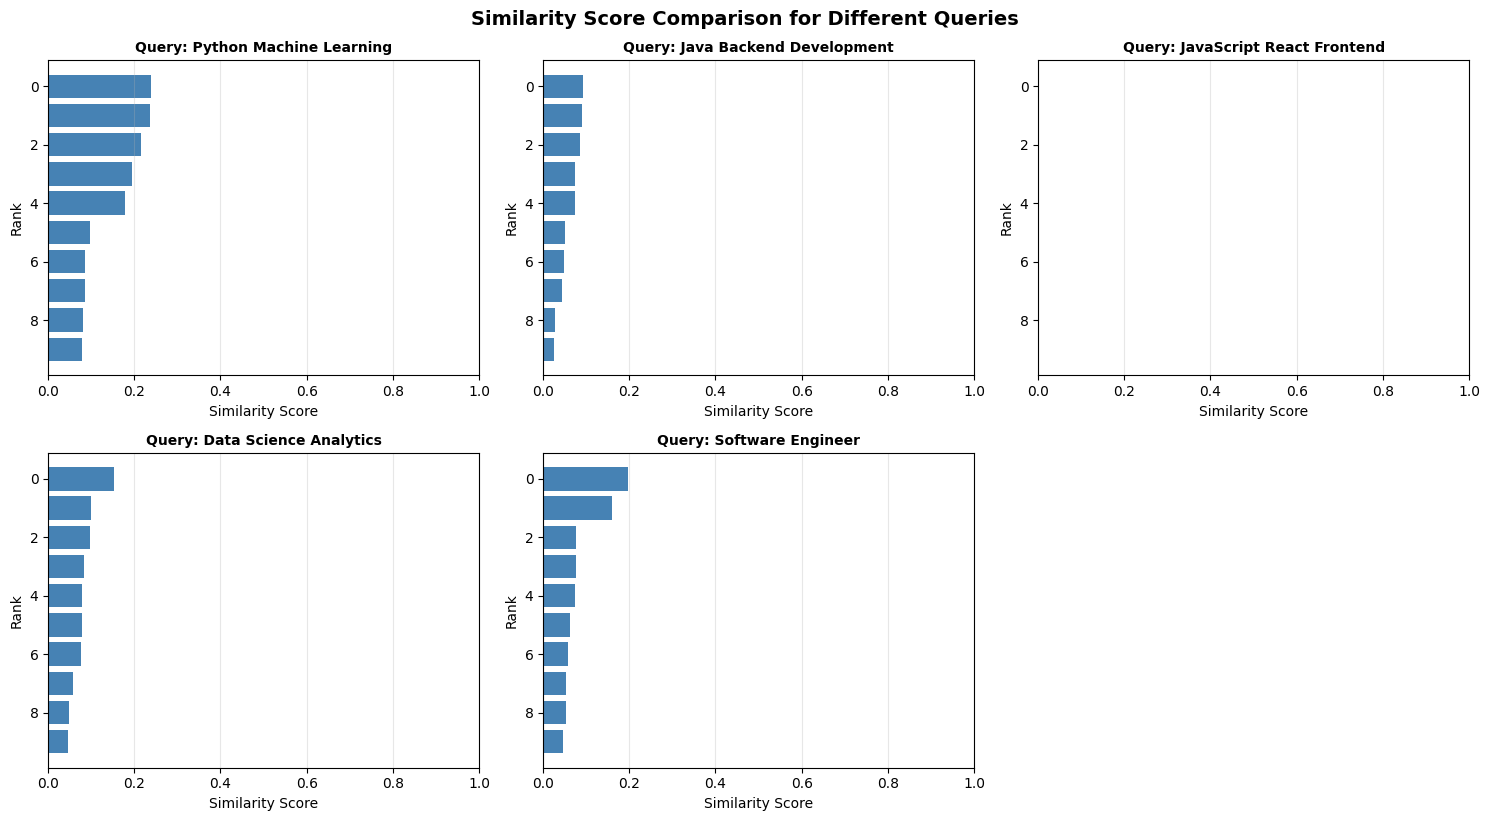

In [29]:
import matplotlib.pyplot as plt

# Test multiple queries and compare results
queries = [
    "Python Machine Learning",
    "Java Backend Development",
    "JavaScript React Frontend",
    "Data Science Analytics",
    "Software Engineer"
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, query in enumerate(queries):
    results = search_cvs(query, top_k=10, show_details=False)

    axes[idx].barh(range(len(results)), results['similarity_score'], color='steelblue')
    axes[idx].set_title(f'Query: {query}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Similarity Score')
    axes[idx].set_ylabel('Rank')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].set_xlim(0, 1)

# Hide sixth plot if empty
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('Similarity Score Comparison for Different Queries',
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [30]:
def interactive_cv_search():
    print("=" * 70)
    print("Interactive CV Search Engine")
    print("=" * 70)
    print("Search for candidates based on skills, experience, or keywords")
    print("=" * 70)

    query = input("\nEnter keywords to search for: ")

    if not query.strip():
        print("No query entered. Thank you for using the search engine!")
        return

    top_k = input("How many results do you want? (default: 5): ")
    top_k = int(top_k) if top_k.strip().isdigit() else 5

    results = search_cvs(query, top_k=top_k, show_details=True)

    max_score = results['similarity_score'].max()
    if max_score < 0.1:
        print("\nWarning: Similarity scores are very low!")
        print("Try different or more general keywords")

    return results


In [31]:
print("=" * 70)
print("CV Search Engine Summary")
print("=" * 70)
print(f"\nNumber of CVs loaded: {len(df_cvs)}")
print(f"Vocabulary size (unique terms): {len(vocabulary)}")
print(f"TF-IDF matrix shape: {cv_vectors.shape}")
print(f"\nSystem ready to search for best candidates!")
print(f"\nExample queries:")
print(f"   - search_cvs('Python Machine Learning')")
print(f"   - search_cvs('Java Spring Boot Backend')")
print(f"   - search_cvs('Data Science SQL Analytics')")
print(f"   - interactive_cv_search()  # For interactive search")
print("=" * 70)

CV Search Engine Summary

Number of CVs loaded: 40
Vocabulary size (unique terms): 1331
TF-IDF matrix shape: (40, 1331)

System ready to search for best candidates!

Example queries:
   - search_cvs('Python Machine Learning')
   - search_cvs('Java Spring Boot Backend')
   - search_cvs('Data Science SQL Analytics')
   - interactive_cv_search()  # For interactive search


---

## Summary

### Key Takeaways

- **TF-IDF** is a simple but effective method for information retrieval
- **Sparse matrices** make TF-IDF scalable to large document collections

### Next Steps

- Explore other scikit-learn datasets (e.g., `fetch_20newsgroups` with different subsets)
- Try advanced techniques like BM25 (can be implemented with sklearn)